<a href="https://colab.research.google.com/github/bpmasters/asa-challenge-24/blob/main/asa-challenge-24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import librosa
import scipy
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')
plt.rcParams['figure.figsize'] = (18, 6)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [78]:
# copy of matlab buffer function
def buffer(signal, frame_size, overlap_size=0):
    step_size = frame_size - overlap_size
    total_frames = int(np.ceil(len(signal) / step_size))

    padded_length = total_frames * step_size + overlap_size
    padded_signal = np.append(signal, np.zeros(padded_length - len(signal)))

    frames = np.lib.stride_tricks.sliding_window_view(padded_signal, frame_size)[::step_size]

    return frames

# gcc phase transform
def gccphat(x, y, max_tau, fs):
    n = max(x.shape[0], y.shape[0])
    # x = x*np.hanning(x.shape[0])
    # y = y*np.hanning(y.shape[0])

    # max_shift = int(n/2)
    max_shift = int(max_tau * fs)
    X = np.fft.rfft(x)
    Y = np.fft.rfft(y)
    R = X*np.conj(Y)

    cc = np.fft.irfft(R/(np.abs(R)+ 1e-10))
    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    tau = np.argmax(np.abs(cc)) - max_shift

    return tau, cc

In [29]:
# import data and normalize to -1:1
fs, h1 = scipy.io.wavfile.read('/content/drive/MyDrive/ASA-Challenge-24/HYD1.wav')
_,  h2 = scipy.io.wavfile.read('/content/drive/MyDrive/ASA-Challenge-24/HYD2.wav')
_,  h3 = scipy.io.wavfile.read('/content/drive/MyDrive/ASA-Challenge-24/HYD3.wav')

h1 = h1.astype(np.float32)/np.iinfo(h1.dtype).max
h2 = h2.astype(np.float32)/np.iinfo(h2.dtype).max
h3 = h3.astype(np.float32)/np.iinfo(h3.dtype).max

ts = np.arange(0, len(h1)/fs, 1/fs)

Text(0, 0.5, 'FFT Coefficient [dBFS]')

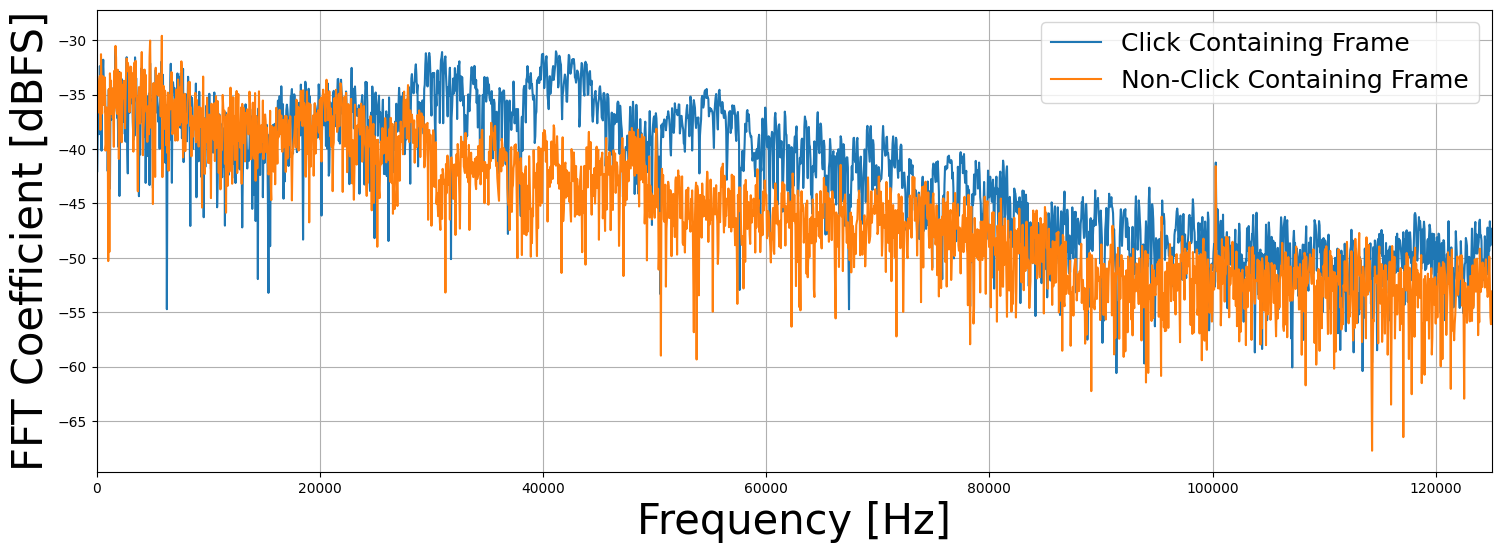

In [30]:
# Plot spectra of hydrophone data during a click and not a click
N = len(h1[int(2.2*fs):int(2.22*fs)])
T = 1/fs
yf = scipy.fftpack.fft(h1[int(2.2*fs):int(2.22*fs)])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 10*np.log10(2.0/N * np.abs(yf[:N//2])), label = 'Click Containing Frame')
plt.xlim(0,125e3)
N = len(h1[int(2.5*fs):int(2.52*fs)])
T = 1/fs
yf = scipy.fftpack.fft(h1[int(2.5*fs):int(2.52*fs)])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
ax.plot(xf, 10*np.log10(2.0/N * np.abs(yf[:N//2])), label = 'Non-Click Containing Frame')
plt.legend(fontsize=18)
plt.grid()
plt.xlabel('Frequency [Hz]', fontsize = 30)
plt.ylabel('FFT Coefficient [dBFS]', fontsize = 30)

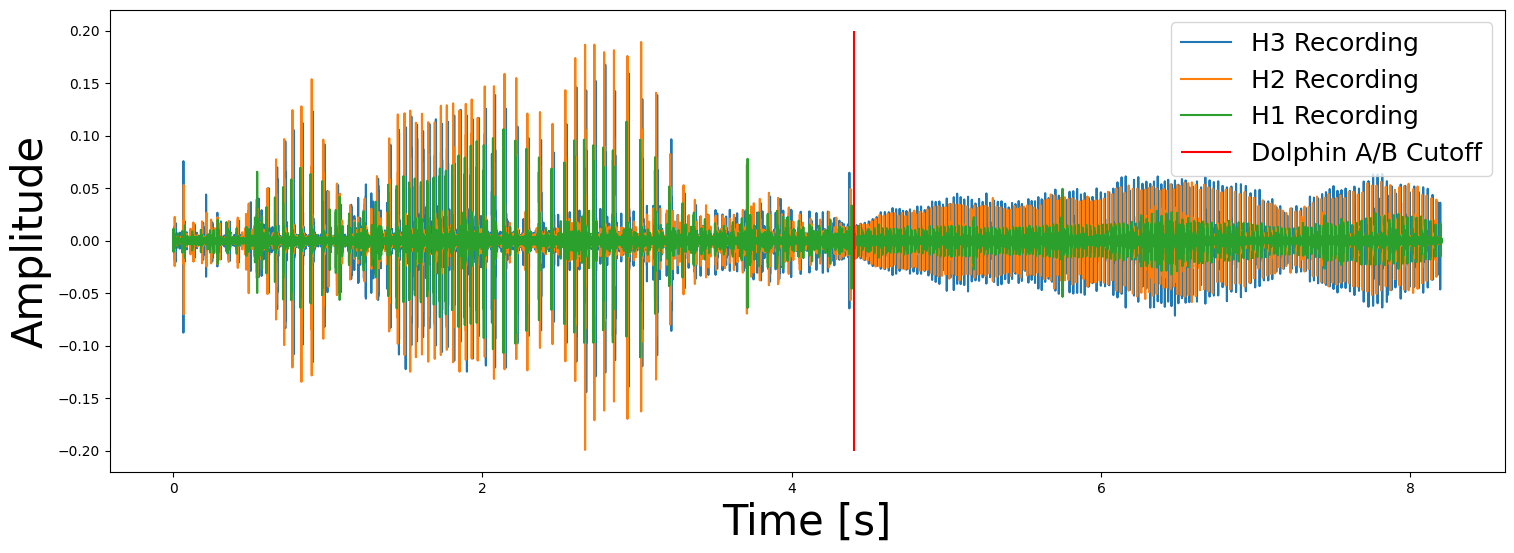

In [45]:
# Develop a bandpass filter based on spectral observations
bpf_l = 25000
bpf_h = 75000
bpf_N = 20
click_cutoff_t = 4.4  # Cutoff time for dolphin A vs. B

# Can verify here using transfer function type filter
[bpf_b, bpf_a] = scipy.signal.butter(bpf_N, [bpf_l, bpf_h], btype='bandpass', fs = fs)
# w, h = scipy.signal.freqz(bpf_b, bpf_a)
# plt.semilogx(w*fs/2/np.pi, 20 * np.log10(abs(h)))

# Implement operation using second order sections for minimal numerical errors
bpf_sos = scipy.signal.butter(bpf_N, [bpf_l, bpf_h], btype='bandpass', fs = fs, output='sos')
h1b = scipy.signal.sosfiltfilt(bpf_sos, h1)
h2b = scipy.signal.sosfiltfilt(bpf_sos, h2)
h3b = scipy.signal.sosfiltfilt(bpf_sos, h3)

plt.figure()
plt.plot(np.arange(0,len(h3b))/fs, h3b, label= 'H3 Recording')
plt.plot(np.arange(0,len(h2b))/fs, h2b, label= 'H2 Recording')
plt.plot(np.arange(0,len(h1b))/fs, h1b, label= 'H1 Recording')
plt.vlines(click_cutoff_t, .2, -.2, 'r', label='Dolphin A/B Cutoff')
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
# plt.title('Hydrophone 2 Recording and Selected Dolphin A/B Cutoff Point', fontsize=30)
plt.legend(fontsize=18)

187.5


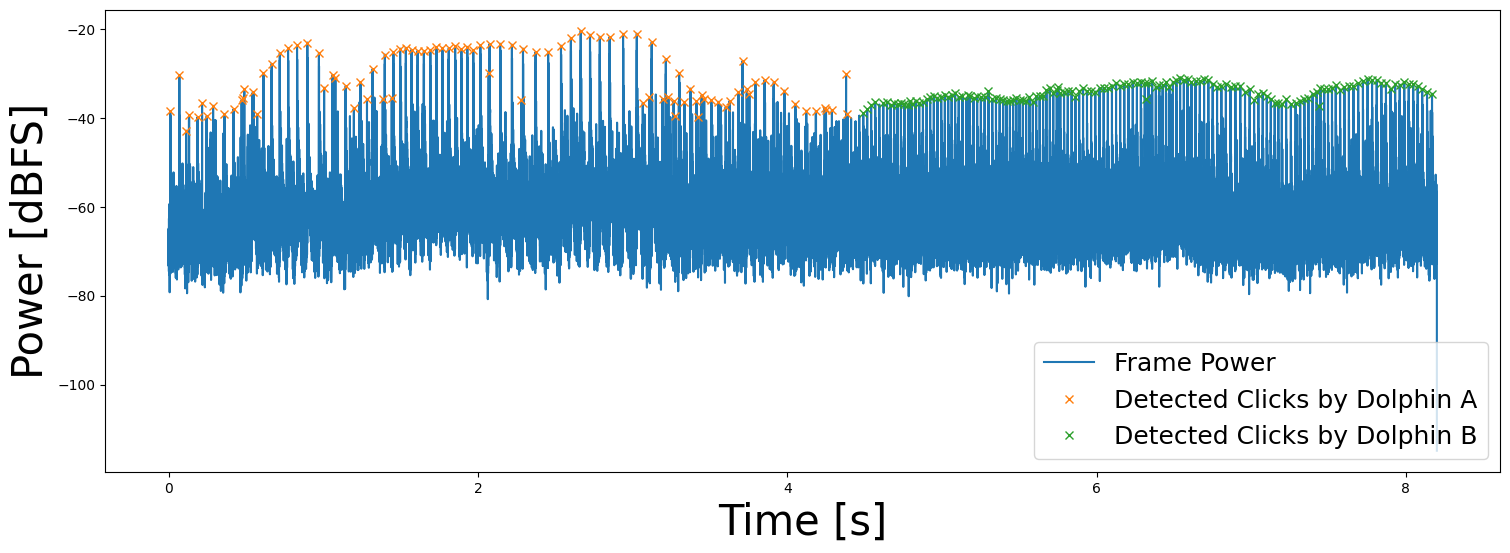

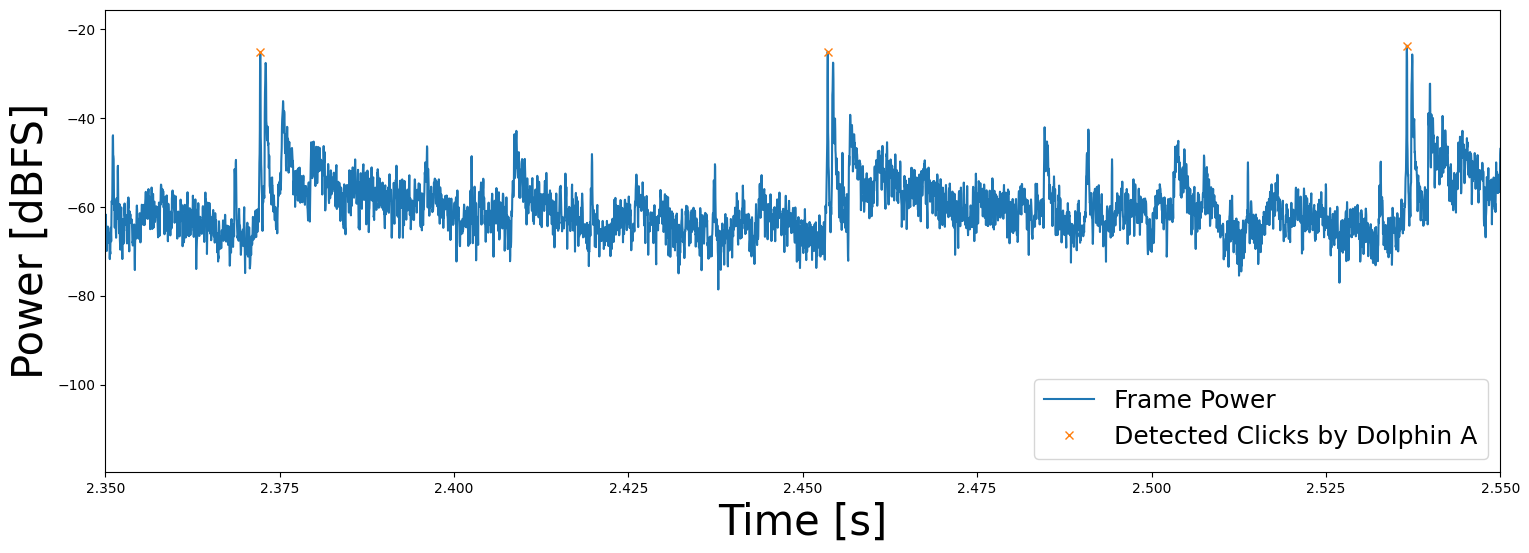

In [46]:
# Analysis Parameters for Simple Click Detection
win_size = 16
noverlap = int(win_size*.5) #np.int(np.ceil(win_size/10)) Use no overlap here for minimal uncertainty
pk_distance = .006 * fs/(win_size-noverlap)  # Distance between peaks, frames based on 7 ms expected ICI
print(pk_distance)
# pk_wlen = 20  # Samples to look around the peak

# Buffer a time signal
ts_buff = buffer(ts, win_size, noverlap)
ts_buff = ts_buff[:,0]

# Buffer the bandpass filtered middle hydrophone signal
h2_buff = buffer(h2b, win_size, noverlap)
h2_buff_pow = 20*np.log10(np.sqrt(np.mean(h2_buff**2,axis=1)))

# Specify parameters for click detection
dB_peak_thresh_a = 35  # Dolphin A threshold
dB_peak_thresh_b = 35  # Dolphin B threshold


# Run prominence based peak detector to find envelope (clicks)
h2_peaks_a, _ = scipy.signal.find_peaks(h2_buff_pow[ts_buff<click_cutoff_t], prominence=dB_peak_thresh_a, distance=pk_distance)
h2_peaks_b, _ = scipy.signal.find_peaks(h2_buff_pow[ts_buff>=click_cutoff_t], prominence=dB_peak_thresh_b, distance=pk_distance)

# Plot the frame by frame power along with the detected click locations
plt.figure()
plt.plot(ts_buff, h2_buff_pow, label='Frame Power')
plt.plot(ts_buff[h2_peaks_a], h2_buff_pow[h2_peaks_a], 'x', label='Detected Clicks by Dolphin A')
plt.plot(ts_buff[ts_buff>=click_cutoff_t][h2_peaks_b], h2_buff_pow[ts_buff>=click_cutoff_t][h2_peaks_b], 'x', label='Detected Clicks by Dolphin B')
plt.xlabel('Time [s]', fontsize = 30)
plt.ylabel('Power [dBFS]', fontsize = 30)
plt.legend(fontsize=18, loc='lower right')
# plt.title(r'Locations of Detected Clicks, Uncertainty = $\pm$' + str(np.round(1000*win_size/fs/2, 3)) + ' ms', fontsize=30)

plt.figure()
plt.plot(ts_buff, h2_buff_pow, label='Frame Power')
plt.plot(ts_buff[h2_peaks_a], h2_buff_pow[h2_peaks_a], 'x', label='Detected Clicks by Dolphin A')
plt.xlim([2.35,2.55])
plt.xlabel('Time [s]', fontsize = 30)
plt.ylabel('Power [dBFS]', fontsize = 30)
plt.legend(fontsize=18, loc='lower right')


Text(0.5, 1.0, 'Locations of Detected Clicks, Uncertainty = $\\pm$0.032 ms')

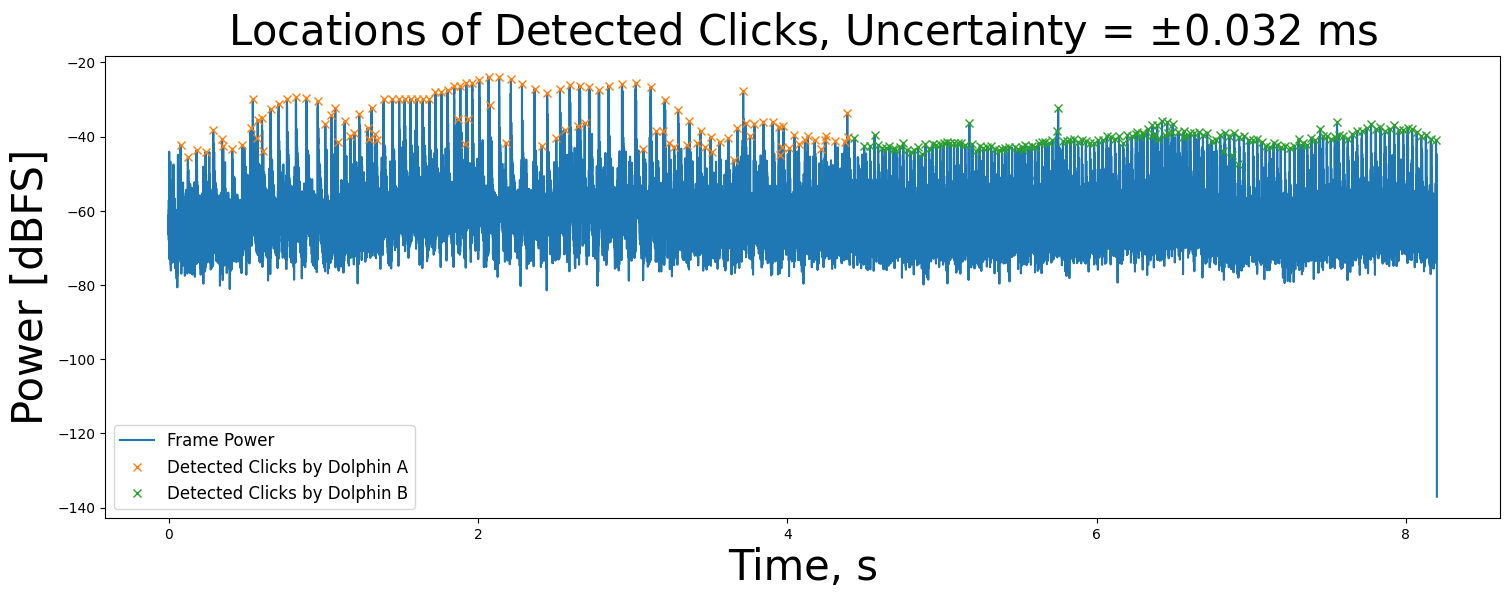

In [47]:

# Analysis Parameters for Simple Click Detection
# Buffer a time signal
ts_buff = buffer(ts, win_size, noverlap)
ts_buff = ts_buff[:,0]

# Buffer the bandpass filtered middle hydrophone signal
h1_buff = buffer(h1b, win_size, noverlap)
h1_buff_pow = 20*np.log10(np.sqrt(np.mean(h1_buff**2,axis=1)))

# Specify parameters for click detection
dB_peak_thresh_a = 30  # Dolphin A threshold
dB_peak_thresh_b = 30  # Dolphin B threshold

# Run prominence based peak detector to find envelope (clicks)
h1_peaks_a, _ = scipy.signal.find_peaks(h1_buff_pow[ts_buff<click_cutoff_t], prominence=dB_peak_thresh_a, distance=pk_distance)
h1_peaks_b, _ = scipy.signal.find_peaks(h1_buff_pow[ts_buff>=click_cutoff_t], prominence=dB_peak_thresh_b, distance=pk_distance)

# Plot the frame by frame power along with the detected click locations
plt.figure()
plt.plot(ts_buff, h1_buff_pow, label='Frame Power')
plt.plot(ts_buff[h1_peaks_a], h1_buff_pow[h1_peaks_a], 'x', label='Detected Clicks by Dolphin A')
plt.plot(ts_buff[ts_buff>=click_cutoff_t][h1_peaks_b], h1_buff_pow[ts_buff>=click_cutoff_t][h1_peaks_b], 'x', label='Detected Clicks by Dolphin B')
plt.xlabel('Time, s', fontsize = 30)
plt.ylabel('Power [dBFS]', fontsize = 30)
plt.legend(fontsize=12)
plt.title(r'Locations of Detected Clicks, Uncertainty = $\pm$' + str(np.round(1000*win_size/fs/2, 3)) + ' ms', fontsize=30)


Text(0.5, 1.0, 'Locations of Detected Clicks, Uncertainty = $\\pm$16.0 $\\mu$s')

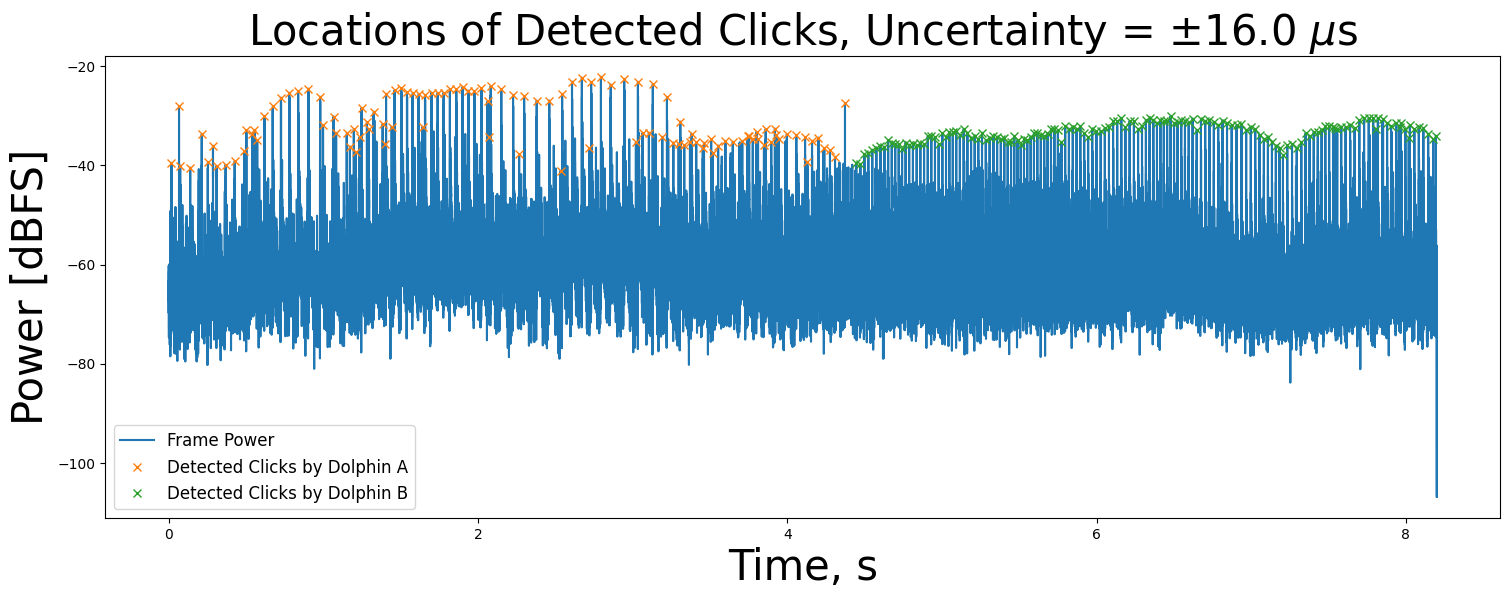

In [48]:
# Analysis Parameters for Simple Click Detection
# Buffer a time signal
ts_buff = buffer(ts, win_size, noverlap)
ts_buff = ts_buff[:,0]

# Buffer the bandpass filtered middle hydrophone signal
h3_buff = buffer(h3b, win_size, noverlap)
h3_buff_pow = 20*np.log10(np.sqrt(np.mean(h3_buff**2,axis=1)))

# Specify parameters for click detection
dB_peak_thresh_a = 35  # Dolphin A threshold
dB_peak_thresh_b = 35  # Dolphin B threshold

# Run prominence based peak detector to find envelope (clicks)
h3_peaks_a, _ = scipy.signal.find_peaks(h3_buff_pow[ts_buff<click_cutoff_t], prominence=dB_peak_thresh_a, distance=pk_distance)
h3_peaks_b, _ = scipy.signal.find_peaks(h3_buff_pow[ts_buff>=click_cutoff_t], prominence=dB_peak_thresh_b, distance=pk_distance)

# Plot the frame by frame power along with the detected click locations
plt.figure()
plt.plot(ts_buff, h3_buff_pow, label='Frame Power')
plt.plot(ts_buff[h3_peaks_a], h3_buff_pow[h3_peaks_a], 'x', label='Detected Clicks by Dolphin A')
plt.plot(ts_buff[ts_buff>=click_cutoff_t][h3_peaks_b], h3_buff_pow[ts_buff>=click_cutoff_t][h3_peaks_b], 'x', label='Detected Clicks by Dolphin B')
plt.xlabel('Time, s', fontsize = 30)
plt.ylabel('Power [dBFS]', fontsize = 30)
plt.legend(fontsize=12)
plt.title(r'Locations of Detected Clicks, Uncertainty = $\pm$' + str(np.round(1000000*(win_size-noverlap)/fs/2, 0)) + r' $\mu$s', fontsize=30)


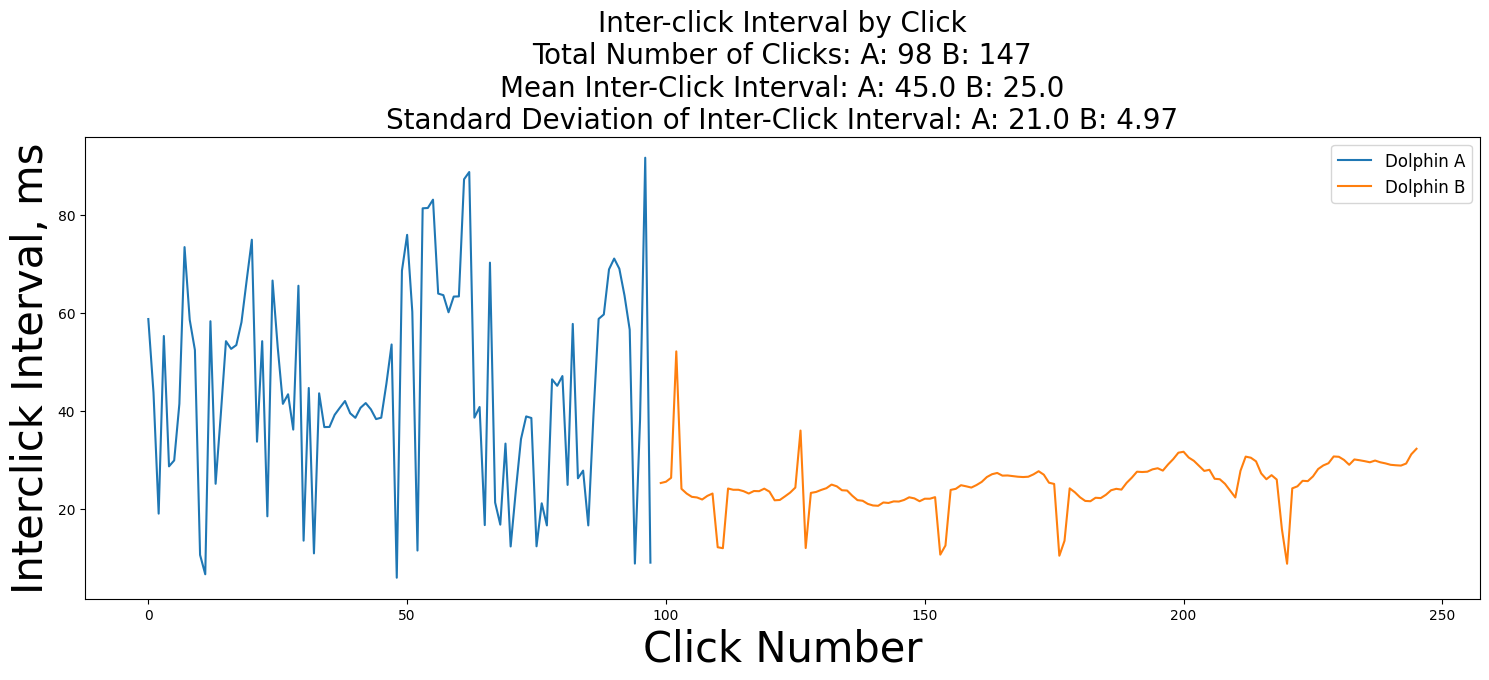

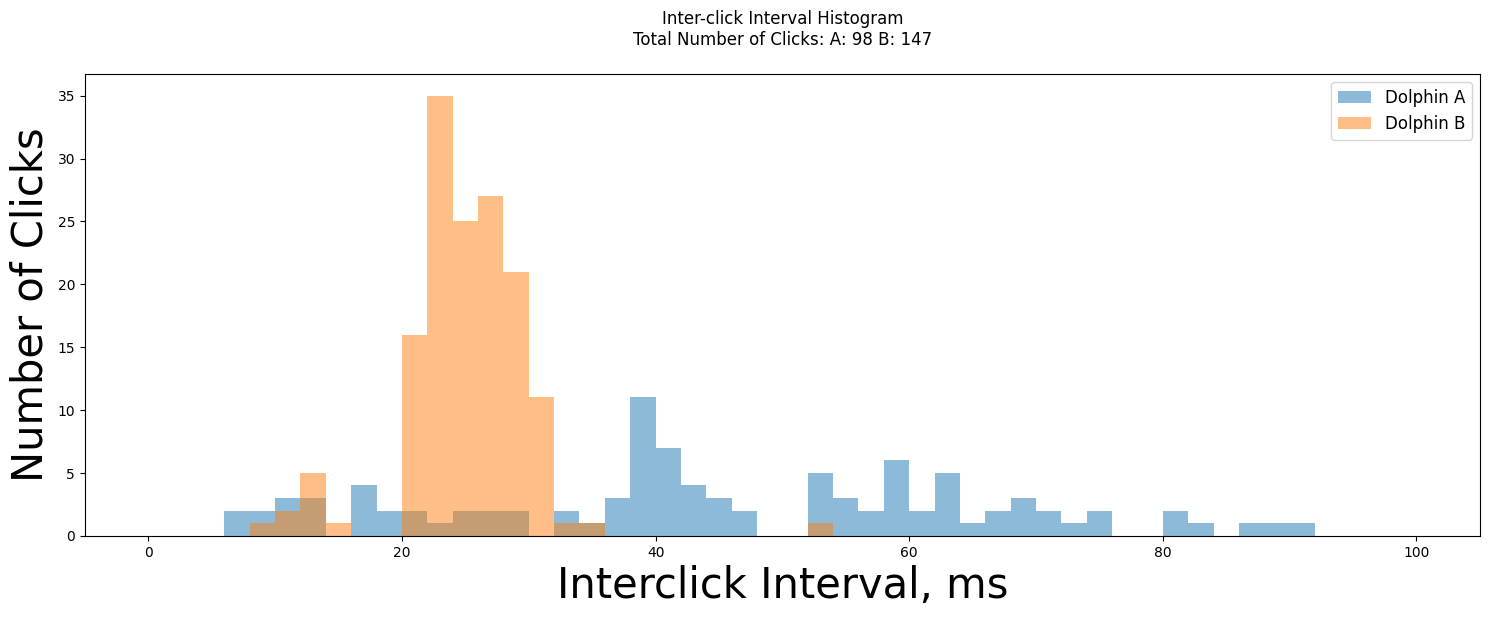

In [51]:
click_cutoff = click_cutoff_t/(len(h2)/fs)

ts_buff_a = ts_buff[0:np.int16(np.floor(click_cutoff*len(ts_buff)))]
h2_buff_pow_a = h2_buff_pow[0:np.int16(np.floor(click_cutoff*len(h2_buff_pow)))]
h2_clicks_a = h2_buff_pow[h2_peaks_a]
h2_click_ts_a = ts_buff[h2_peaks_a]

ts_buff_b = ts_buff[np.int16(np.ceil(click_cutoff*len(ts_buff))):]
h2_buff_pow_b = h2_buff_pow[np.int16(np.ceil(click_cutoff*len(h2_buff_pow))):]
h2_clicks_b = h2_buff_pow[h2_peaks_b]
h2_click_ts_b = ts_buff[h2_peaks_b]

# Plotting the interclick interval by click number, along with some statistics
ici_a = np.diff(h2_click_ts_a)*1000
ici_b = np.diff(h2_click_ts_b)*1000

plt.figure()
plt.plot(np.arange(0,len(ici_a)), ici_a, label='Dolphin A')
plt.plot(np.arange(len(ici_a)+1,len(ici_b)+len(ici_a)+1), ici_b, label='Dolphin B')
plt.ylabel('Interclick Interval, ms', fontsize = 30)
plt.xlabel('Click Number', fontsize = 30)
plt.title('Inter-click Interval by Click' + '\n' + 'Total Number of Clicks: ' + 'A: ' + str(len(ici_a)) + ' B: ' + str(len(ici_b)) + '\n'
          + 'Mean Inter-Click Interval: A: ' + str(np.round(np.mean(ici_a))) + ' B: ' + str(np.round(np.mean(ici_b))) + '\n'
          + 'Standard Deviation of Inter-Click Interval: A: ' + str(np.round(np.std(ici_a))) + ' B: ' + str(np.round(np.std(ici_b),2)), fontsize = 20)
plt.legend(fontsize=12)

plt.figure()
plt.hist(ici_a, bins=np.linspace(0,100,51), alpha=0.5, label='Dolphin A')
plt.hist(ici_b, bins=np.linspace(0,100,51), alpha=0.5, label='Dolphin B')
plt.xlabel('Interclick Interval, ms', fontsize = 30)
plt.ylabel('Number of Clicks', fontsize = 30)
plt.title('Inter-click Interval Histogram' + '\n' + 'Total Number of Clicks: ' + 'A: ' + str(len(ici_a)) + ' B: ' + str(len(ici_b)) + '\n')
plt.legend(fontsize=12)

# print(np.linspace(0,100,21))

In [52]:
print(h2_peaks_a)
print(h1_peaks_a)

[   324   2159   3526   4122   5849   6746   7681   8976  11269  13099
  14737  15070  15280  17101  17887  19112  20806  22451  24120  25935
  28016  30356  31410  33104  33683  35763  37418  38713  40069  41200
  43247  43671  45067  45410  46772  47919  49067  50292  51562  52875
  54110  55316  56586  57886  59146  60344  61551  62975  64648  64836
  66979  69350  71231  71592  74132  76674  79269  81266  83253  85131
  87109  89088  91813  94584  95791  97066  97589  99783 100450 100976
 102018 102405 103148 104219 105434 106639 107027 107689 108210 109661
 111071 112543 113322 115126 115947 116817 117338 118562 120398 122262
 124413 126633 128788 130772 132539 132817 134013 136875 137159]
[  2404   3873   5623   7454   9013  10796  11020  12850  14820  16634
  16997  17770  17987  18863  19112  20579  22225  23893  25708  27789
  30129  31656  32877  33664  34161  35559  36736  37530  38510  40182
  40548  40998  41698  42062  43468  45206  46568  47692  48862  50090
  51357  526

##TASK 2

In [76]:
d = 14  # meters, separating hydrophones
c = 1520  # m/s, speed of sound in water
max_td = d/c

click_cutoff = int(click_cutoff_t * fs)

print(max_td)

0.009210526315789473


### Dolphin A

16
287
8
-1811


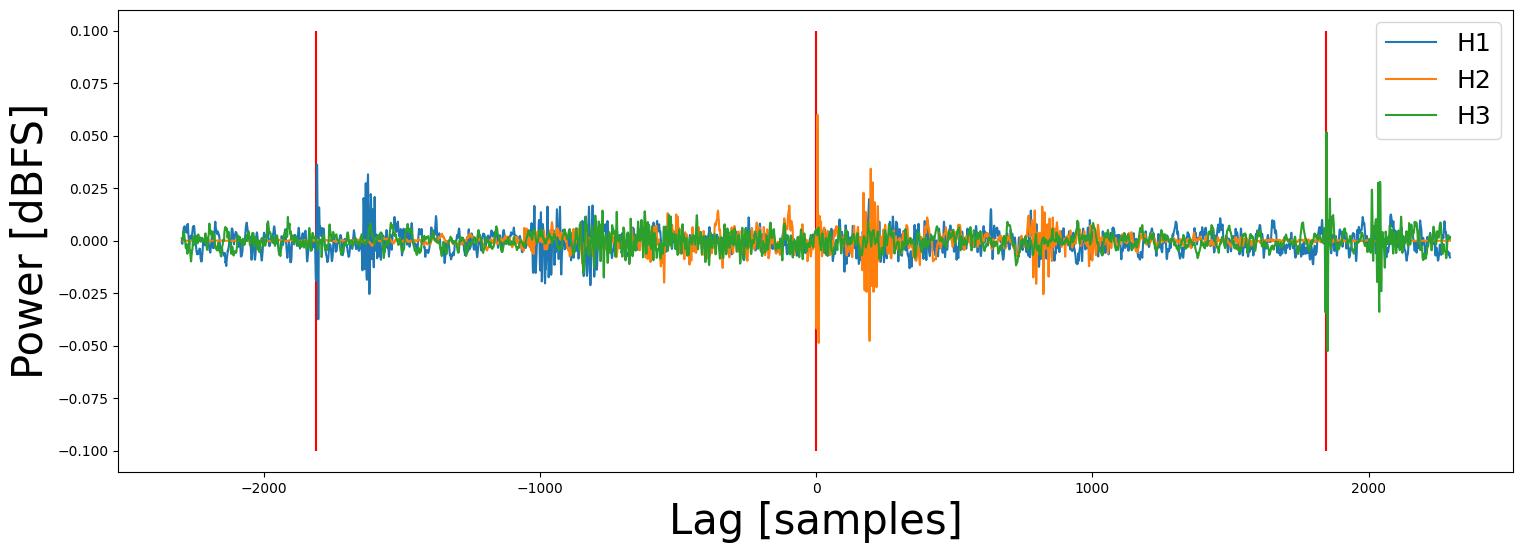

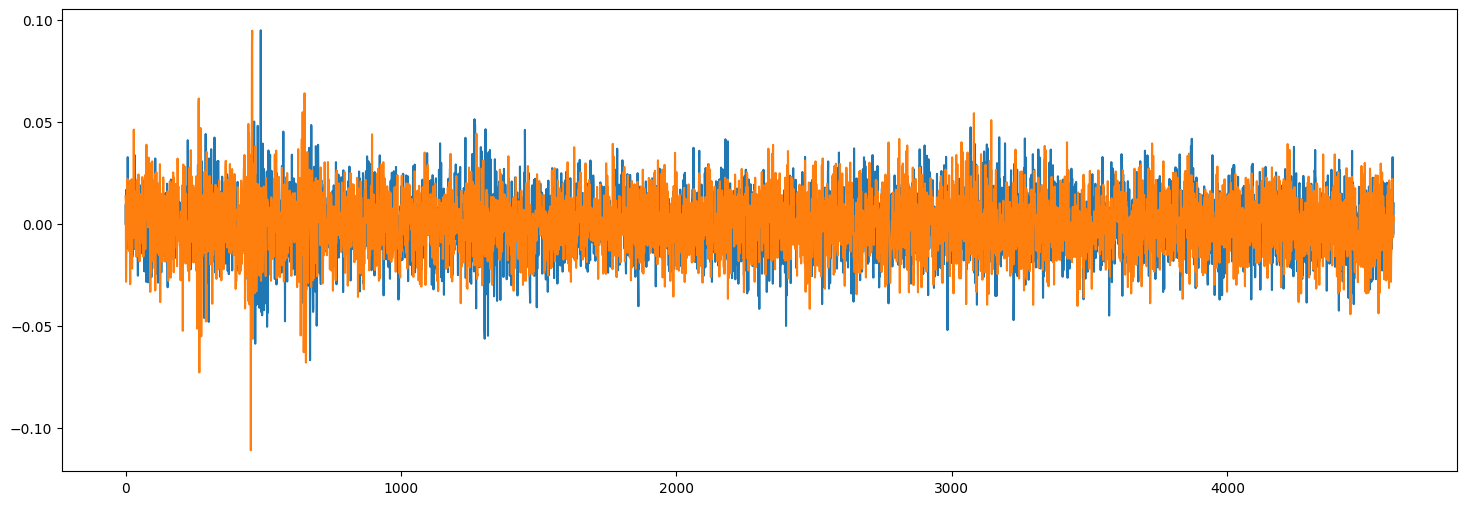

In [112]:
# Better idea:

lags_12 = []
lags_23 = []
h2_good_peaks = []

win_width = int(np.ceil(max_td*fs)/(win_size-noverlap))
frame_to_sample = win_size-noverlap
print(win_size)
print(win_width)
print(frame_to_sample)
for i, peak in enumerate(h2_peaks_a[:-8]):
  # only run gcc if theres peaks in both other hydrophones
  if (np.abs(h1_peaks_a - peak) < win_width).any() and (np.abs(h3_peaks_a - peak) < win_width).any():

    post_win = win_width
    pre_win = win_width

    h2_good_peaks.append(peak)

    non_win_loc = peak
    # h1_sig = h1_buff_pow[non_win_loc-pre_win:non_win_loc+post_win]
    # h2_sig = h2_buff_pow[non_win_loc-pre_win:non_win_loc+post_win]
    # h3_sig = h3_buff_pow[non_win_loc-pre_win:non_win_loc+post_win]

    h1_sig = h1[frame_to_sample*(non_win_loc-pre_win):frame_to_sample*(non_win_loc+post_win)]
    h2_sig = h2[frame_to_sample*(non_win_loc-pre_win):frame_to_sample*(non_win_loc+post_win)]
    h2_sig = h2_sig*np.hanning(len(h2_sig))
    h3_sig = h3[frame_to_sample*(non_win_loc-pre_win):frame_to_sample*(non_win_loc+post_win)]

    # h1_sig = h1_sig*np.hanning(len(h1_sig))
    # h2_sig = h2_sig*np.hanning(len(h2_sig))
    # h3_sig = h3_sig*np.hanning(len(h3_sig))

    lag_12, cc_12 = gccphat(h1_sig, h2_sig, max_td, fs)
    lag_23, cc_23 = gccphat(h2_sig, h3_sig, max_td, fs)

    lags_12.append(lag_12)
    lags_23.append(lag_23)

plt.figure()
plt.vlines(0, -.1, .1, 'r')
plt.vlines(lag_12, -.1, .1, 'r')
plt.vlines(-lag_23, -.1, .1, 'r')
plt.plot(-len(h1_sig)/2+np.arange(0,len(h1_sig)), h1_sig, label='H1')
plt.plot(-len(h2_sig)/2+np.arange(0,len(h2_sig)), h2_sig, label='H2')
plt.plot(-len(h3_sig)/2+np.arange(0,len(h3_sig)), h3_sig, label='H3')


plt.xlabel('Lag [samples]', fontsize = 30)
plt.ylabel('Power [dBFS]', fontsize = 30)
plt.legend(fontsize=18)

# plt.figure()
# plt.plot(lags_12)
# plt.plot(lags_23)

print(lag_12)

plt.figure()
plt.plot(cc_12)
plt.plot(cc_23)
# np.argmax(np.abs(cc_12))


-926.8133333333334 -1206.6933333333334
1395.0150268565408 1080.9240734770515


(-1.0, 19.0)

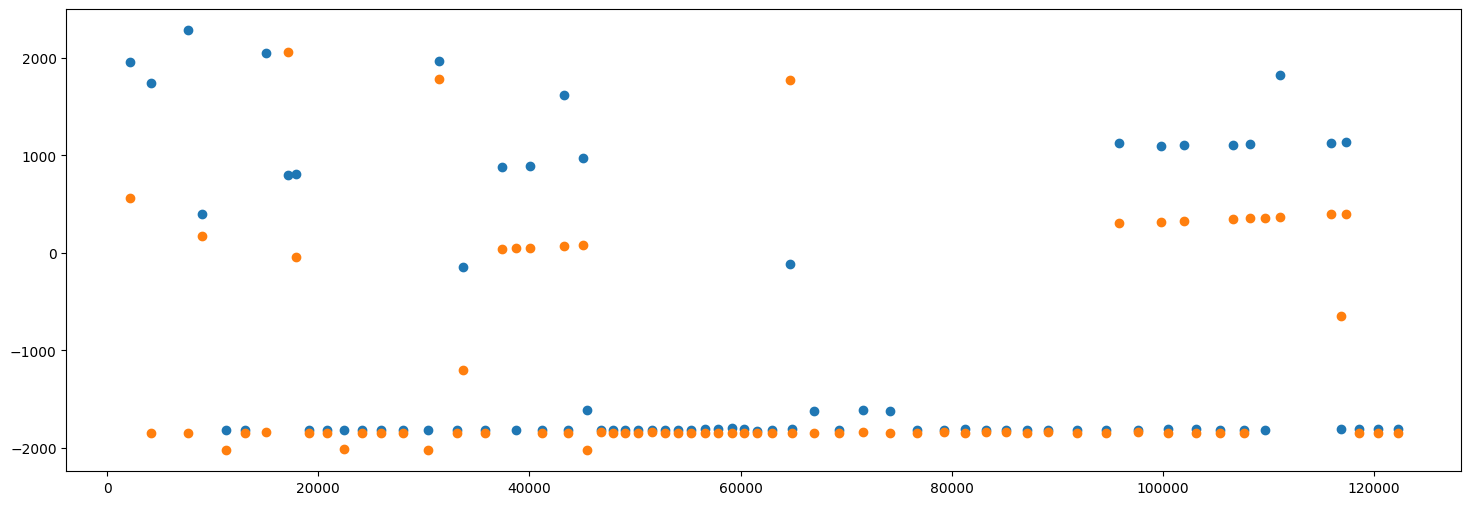

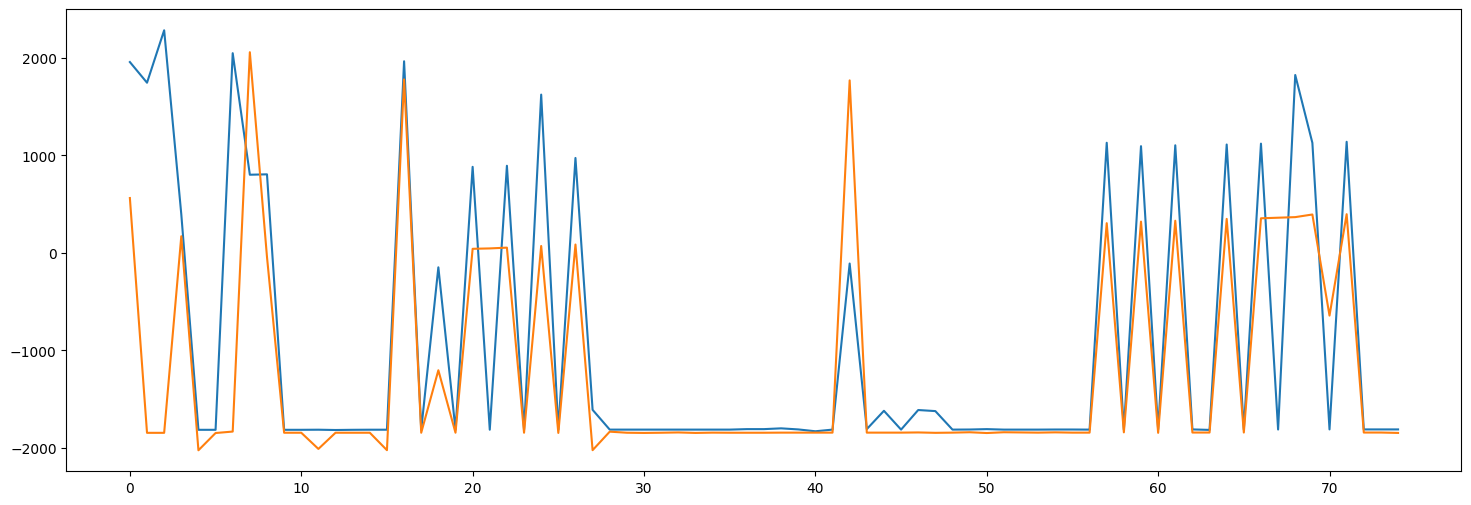

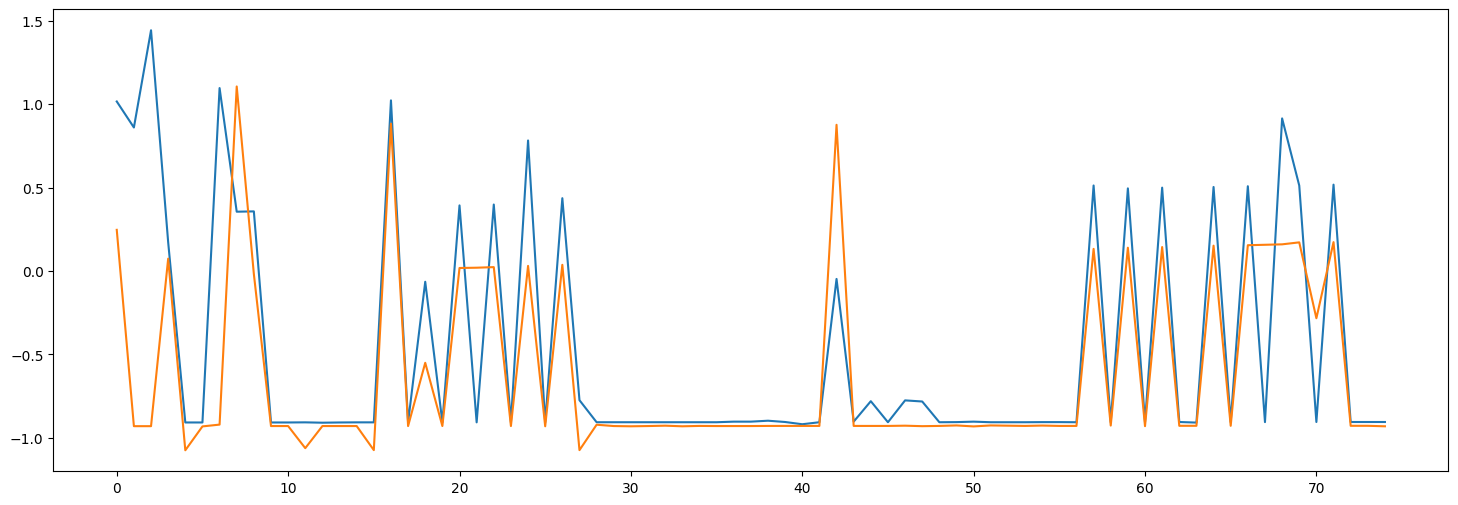

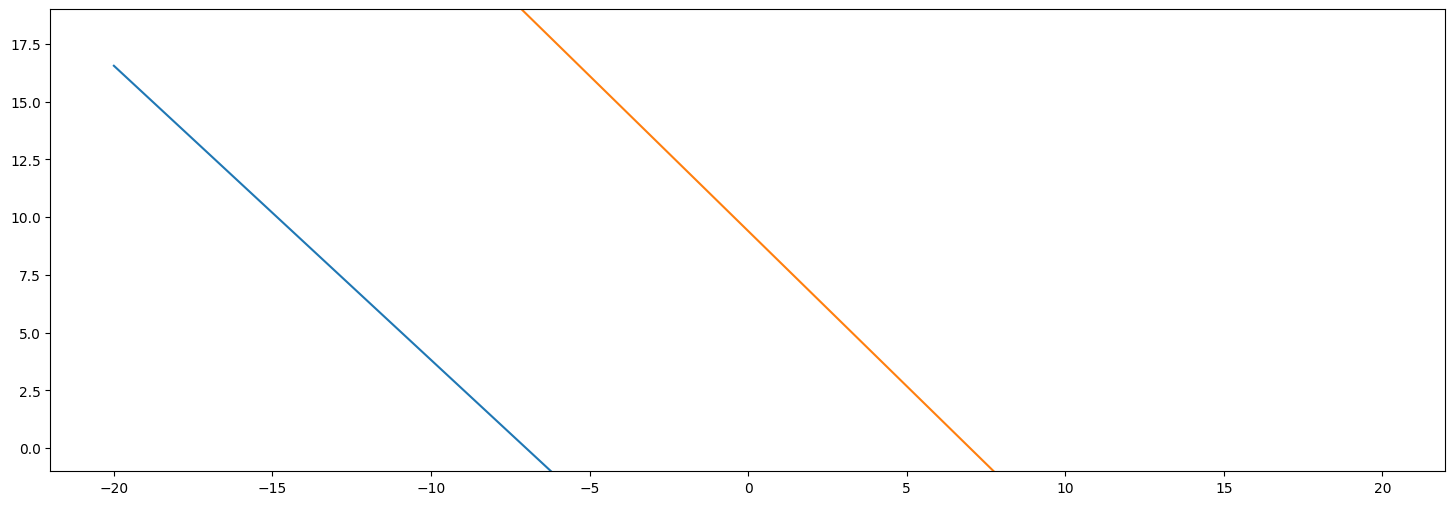

In [113]:
lags_12 = np.array(lags_12)
lags_23 = np.array(lags_23)

plt.figure()
plt.scatter(h2_good_peaks, lags_12)
plt.scatter(h2_good_peaks, lags_23)

print(np.mean(lags_12), np.mean(lags_23))
print(np.std(lags_12), np.std(lags_23))

good_inds = (np.abs(lags_23 - np.mean(lags_23)) < np.std(lags_23)) & (np.abs(lags_12 - np.mean(lags_12)) < np.std(lags_12))
filt_lags_12 = lags_12#[good_inds]
filt_lags_23 = lags_23#[good_inds]

plt.figure()
plt.plot(filt_lags_12)
plt.plot(filt_lags_23)

angles_12 = np.arcsin(filt_lags_12/(fs*max_td))
angles_23 = np.arcsin(filt_lags_23/(fs*max_td))

plt.figure()
plt.plot(angles_12)
plt.plot(angles_23)

slopes_12 = np.tan(angles_12)
slopes_23 = np.tan(angles_23)

x = np.arange(-20,20,.01)
rays_12 = np.ndarray([len(angles_12), len(x)])
rays_23 = np.ndarray([len(angles_23), len(x)])

for i, a in enumerate(angles_12):
  rays_12[i, :] = slopes_12[i]*(x+7)

for i, a in enumerate(angles_23):
  rays_23[i, :] = slopes_23[i]*(x-7)
plt.figure()
plt.plot(x, rays_12[-1, :])
plt.plot(x, rays_23[-1, :])
plt.ylim([-1, 19])

### Dolphin B

16
287


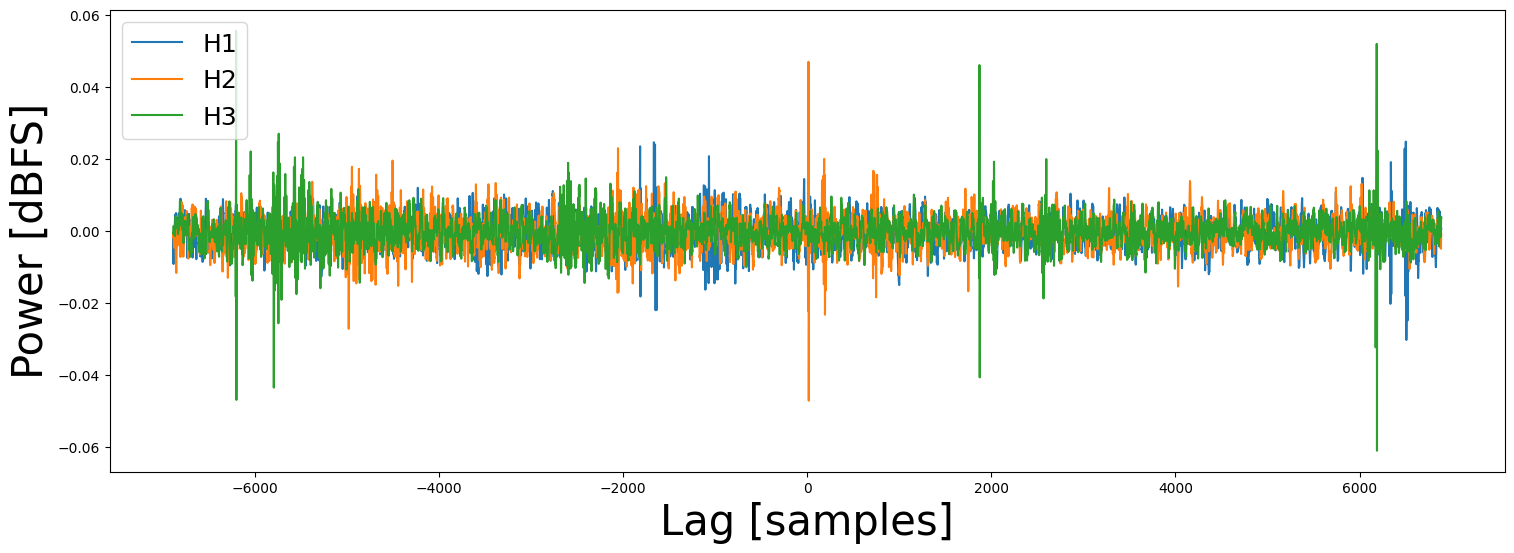

In [82]:
# Dolphin B

lags_12 = []
lags_23 = []

win_width = int(np.ceil(max_td*fs)/(win_size-noverlap))
frame_to_sample = win_size-noverlap
print(win_size)
print(win_width)
for i, peak in enumerate(h2_peaks_b):
  # only run gcc if theres peaks in both other hydrophones
  if (np.abs(h1_peaks_b - peak) < win_width).any() and (np.abs(h3_peaks_b - peak) < win_width).any():
    non_win_loc = peak + int(click_cutoff_t*fs/(win_size-noverlap))#*frame_to_sample


    post_win = 3*win_width
    pre_win = 3*win_width

    # h1_sig = h1_buff_pow[non_win_loc-pre_win:non_win_loc+post_win]
    # h2_sig = h2_buff_pow[non_win_loc-pre_win:non_win_loc+post_win]
    # h3_sig = h3_buff_pow[non_win_loc-pre_win:non_win_loc+post_win]

    h1_sig = h1[frame_to_sample*(non_win_loc-pre_win):frame_to_sample*(non_win_loc+post_win)]
    h2_sig = h2[frame_to_sample*(non_win_loc-pre_win):frame_to_sample*(non_win_loc+post_win)]
    h3_sig = h3[frame_to_sample*(non_win_loc-pre_win):frame_to_sample*(non_win_loc+post_win)]

    # h1_sig = h1_sig*np.hanning(len(h1_sig))
    # h2_sig = h2_sig*np.hanning(len(h2_sig))
    # h3_sig = h3_sig*np.hanning(len(h3_sig))

    lag_12, cc_12 = gccphat(h1_sig, h2_sig, max_td, fs)
    lag_23, cc_23 = gccphat(h3_sig, h2_sig, max_td, fs)

    lags_12.append(lag_12)
    lags_23.append(lag_23)

plt.figure()
plt.plot(-len(h1_sig)/2+np.arange(0,len(h1_sig)), h1_sig, label='H1')
plt.plot(-len(h2_sig)/2+np.arange(0,len(h2_sig)), h2_sig, label='H2')
plt.plot(-len(h3_sig)/2+np.arange(0,len(h3_sig)), h3_sig, label='H3')
# plt.vlines(0, -70, -40, 'r')
# plt.vlines(lag_12, -70, -40, 'r')
# plt.vlines(abs(lag_23), -70, -40, 'r')
plt.xlabel('Lag [samples]', fontsize = 30)
plt.ylabel('Power [dBFS]', fontsize = 30)
plt.legend(fontsize=18)



1333.5744680851064 1705.22695035461
1012.7574691223042 699.8894073609699
[-6.84544244e-01  9.17868604e-01  9.05810797e-01  9.11461687e-01
 -4.85242475e-01  8.06374809e-01  8.06374809e-01  9.18583795e-01
  9.09337798e-01 -6.23788406e-01  8.17736865e-01  8.17736865e-01
  9.17868604e-01  9.17868604e-01  8.17736865e-01  8.15833684e-01
  8.15833684e-01  8.12670237e-01  8.16467649e-01  9.17868604e-01
  8.13934344e-01  8.09517324e-01  8.15833684e-01  8.17736865e-01
  9.37420886e-01  8.15833684e-01  8.03868194e-01  8.03868194e-01
  8.05747542e-01  9.17154082e-01  8.13934344e-01  8.13934344e-01
  8.01992504e-01  8.01992504e-01  8.11407815e-01  8.12670237e-01
  8.01992504e-01  8.01992504e-01  8.12670237e-01  8.01992504e-01
  8.12670237e-01  8.07002487e-01  8.07002487e-01  8.13934344e-01
  8.01368082e-01  8.15200145e-01  8.15200145e-01  8.01368082e-01
  8.12670237e-01  8.01368082e-01 -4.34285728e-04  1.47320889e-01
  1.47320889e-01  1.13592701e-01  8.05120685e-01  8.15833684e-01
  8.03868194e-01 

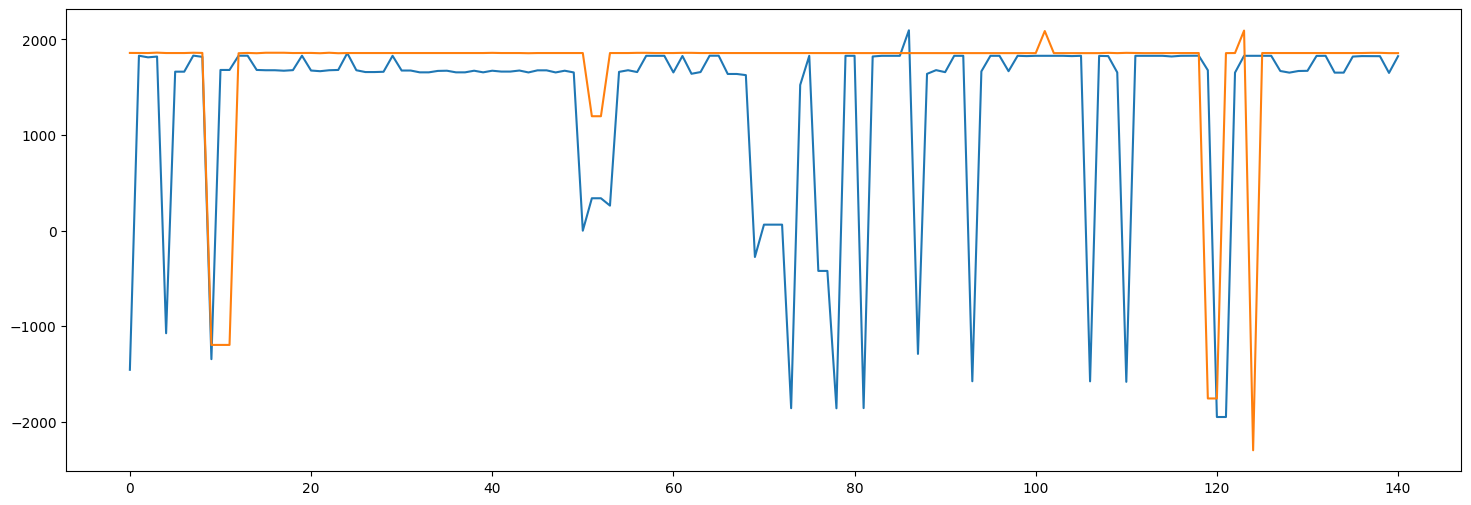

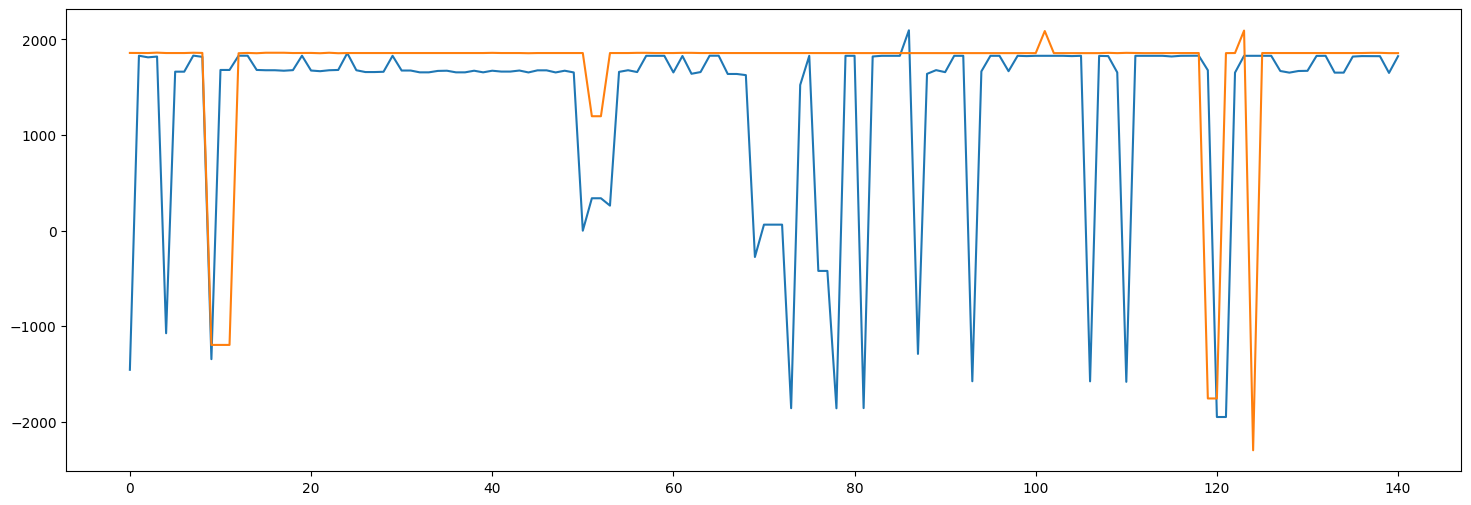

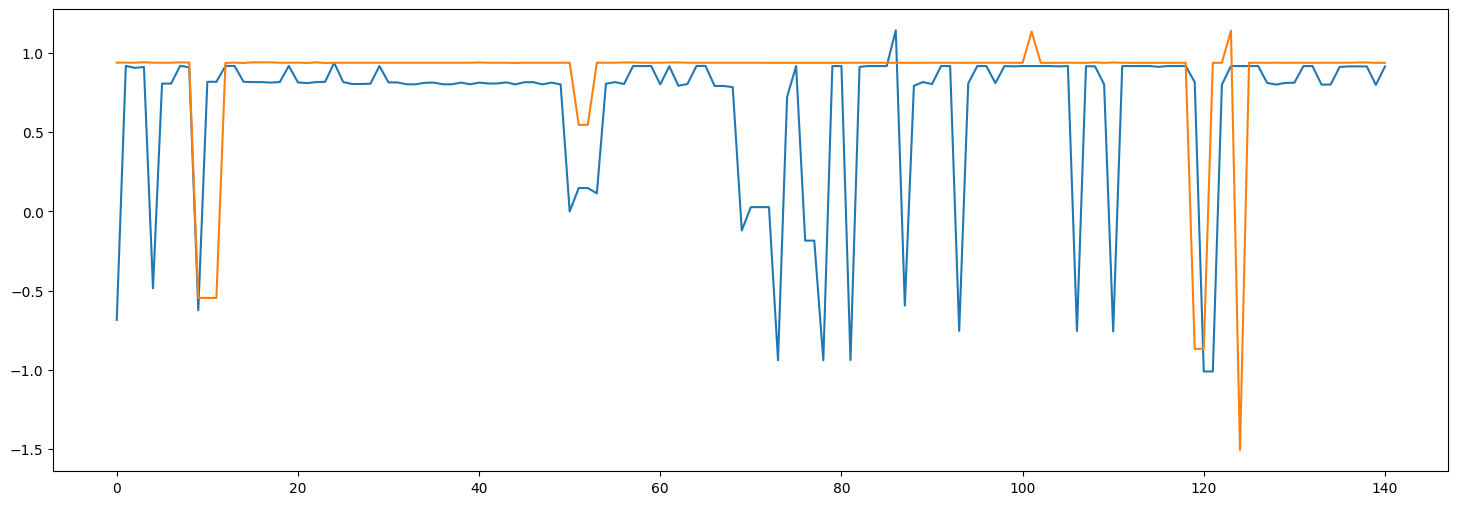

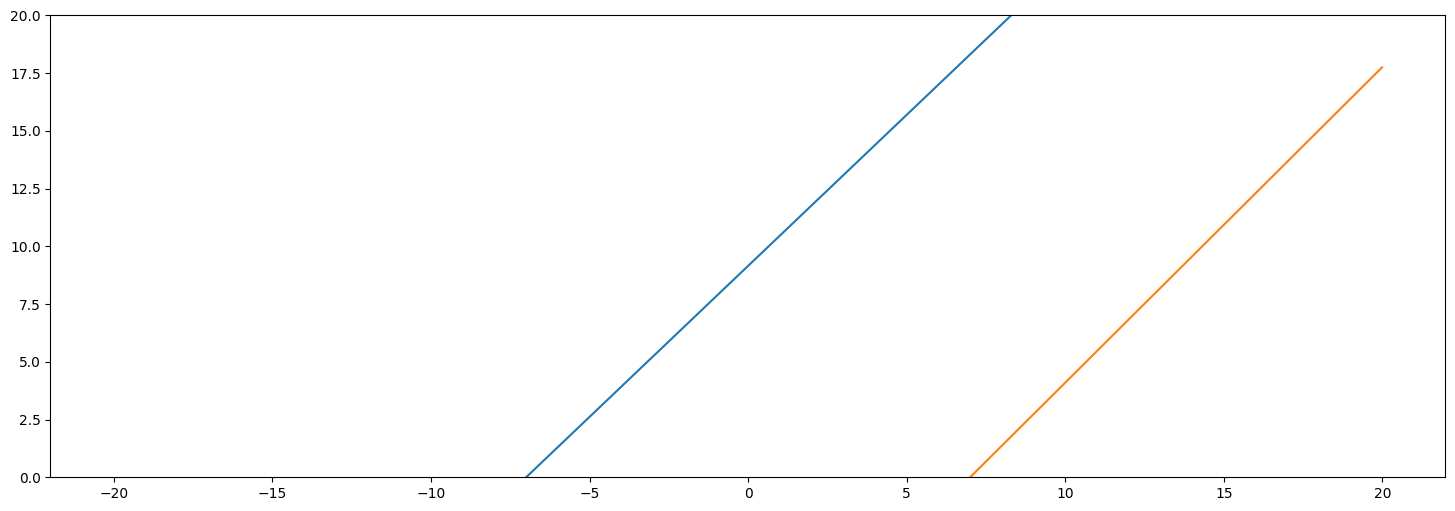

In [83]:
lags_12 = -np.array(lags_12)
lags_23 = np.array(lags_23)


plt.figure()
plt.plot(lags_12)
plt.plot(lags_23)

print(np.mean(lags_12), np.mean(lags_23))
print(np.std(lags_12), np.std(lags_23))
good_inds = (np.abs(lags_23 - np.mean(lags_23)) < np.std(lags_23)) & (np.abs(lags_12 - np.mean(lags_12)) < np.std(lags_12))
filt_lags_12 = lags_12#[good_inds]
filt_lags_23 = lags_23#[good_inds]
# filt_lags_12 = lags_12[np.abs(lags_12 - np.mean(lags_12)) < np.std(lags_12)]
# filt_lags_23 = lags_23[np.abs(lags_23 - np.mean(lags_23)) < np.std(lags_23)]

plt.figure()
plt.plot(filt_lags_12)
plt.plot(filt_lags_23)

angles_12 = np.arcsin(filt_lags_12/(fs*max_td))
angles_23 = np.arcsin(filt_lags_23/(fs*max_td))

plt.figure()
plt.plot(angles_12)
plt.plot(angles_23)

slopes_12 = np.tan(angles_12)
slopes_23 = np.tan(angles_23)

x = np.arange(-20,20,.01)
rays_12 = np.ndarray([len(angles_12), len(x)])
rays_23 = np.ndarray([len(angles_23), len(x)])

for i, a in enumerate(angles_12):
  rays_12[i, :] = slopes_12[i]*(x+7)

for i, a in enumerate(angles_23):
  rays_23[i, :] = slopes_23[i]*(x-7)

plt.figure()
plt.plot(x, rays_12[1, :])
plt.plot(x, rays_23[1, :])
plt.ylim([0, 20])
print(angles_12)

In [58]:
print(len(h1_peaks_a))
print(len(h2_peaks_a))
print(len(h3_peaks_a))

116
99
115
